- BUFR에 의해 adaptation된 model (class별로 distribution이 matching된것은 아니지만, class-marginal distribution은 matching 되었으므로 penultimate layer distribution에 차이가 있을 것)
- 위 model은 여전히 stats_layer에 adaptation 이전의 source train data statistic을 저장하고 있음 (필요 없음, 게다가 soft bins statistic임)
- soft bins을 그냥 그대로 잘 비교해봐도 괜찮겠지만 source data -> unadapted model distribution과 target data -> adapted model간의 비교는 어려워질 것이니, adapted model의 stats_layer (soft bins) 제거해버리고 다시 (bins) 붙여서 해도 될듯?
- 그러므로 위의 model에서 stats layer buffer 안의 train data statistic만 제거하고, cifar10c test data 및 cifar10 test data를 통과시킨 model을 다시 저장해서 (처음의 pretrained model을 갖고 했던 것과 같은 과정) distribution 다시 확인

In [7]:
from __future__ import division, print_function, absolute_import
import argparse
import yaml
import time
from nets import MNISTCNNBase, ResNet18, learner_distances, add_stats_layer_to_resnet_named_modules, \
    add_stats_layers_to_cnn_classifier, add_stats_layers_to_cnn_everywhere
import nets_wilds
from lib.utils import *
from lib.stats_layers import *
from lib.data_utils import get_static_emnist_dataloaders, get_static_emnist_dataloaders_fewshot, \
    get_cifar10c_dataloaders, get_cifar100c_dataloaders, per_hospital_wilds_dataloader, \
    per_hospital_wilds_dataloader_fewshot
from data.digits import *

In [8]:
# 뭐랑 뭐를 비교하고 싶은지에 따라 다름 (cifar10, cifar10test, cifar10c)
source_dataset_name = "cifar10test"
target_dataset_name = "cifar10c"
output_dir = "."
n_classes = 10
stats_layers = ["bins"]
dev=torch.device('cpu')
seeds = 123 
# bufr로 한차례 distribution align 시킨 adapted model에 대해 관찰
adapted = True

source_ckpt_dir = os.path.join(output_dir, "ckpts", source_dataset_name)
target_ckpt_dir = os.path.join(output_dir, "ckpts", target_dataset_name)

if adapted:
    source_ckpt_dir = os.path.join(source_ckpt_dir,"adapted")
    target_ckpt_dir = os.path.join(target_ckpt_dir,"adapted")

In [9]:
learner = ResNet18(n_classes=n_classes)
modules_to_track = ['linear']
module_features_out = [n_classes]
module_features_in = [512]

for stats_layer in stats_layers:
    add_stats_layer_to_resnet_named_modules(learner, modules_to_track, module_features_out,
                                            module_features_in, stats_layer_type=stats_layer,
                                            surprise_score="PSI",
                                            tau=0.01)
    for learner_stats_layer in learner.stats_layers:
        learner_stats_layer.calc_surprise = True
    learner_stats_layers = learner.stats_layers


In [10]:
# raw bin count이기 때문에 distribution이라기보다는 아직 bin count
def get_distribution(ckpt_dir, class_num):

    ckpt_name = get_ckpt_name(200, "resnet18", 123, "bins", f'0.01_{class_num}')
    if adapted:
        ckpt_name = "pretrain-learner-0_" + ckpt_name
    _, p_model = load_ckpt('pretrain-learner', learner, os.path.join(ckpt_dir, ckpt_name), dev)
    distribution = p_model.linear[0].bin_counts.detach().clone().cpu().numpy()

    return distribution

def vis_histogram(source_ckpt_dir, target_ckpt_dir, class_num, feat_index):
    source_d = get_distribution(source_ckpt_dir, class_num)
    target_d = get_distribution(target_ckpt_dir, class_num)
    source_d /= source_d.sum()
    target_d /= target_d.sum()
    plt.plot(source_d[feat_index], label="source")
    plt.plot(target_d[feat_index], label="target")
    plt.legend()


In [11]:
def get_sum_divergence(ckpt_dir):
    sum_divergence = np.zeros(module_features_in[0])

    for class_p in range(n_classes):
        for class_q in range(n_classes):

            # 오짜피 0이여서 상관없긴 함
            if class_p==class_q:
                continue

            p_distribution = get_distribution(ckpt_dir, class_p)
            q_distribution = get_distribution(ckpt_dir, class_q)

            #divergence.shape : (num_features,) class_p에서와 class_q
            #QUESTION: fast랑 slow가 정확히 어떻게 다르지?
            divergence = surprise_bins(p_distribution, q_distribution, score_type="PSI", fast=True)
            sum_divergence += divergence

    return sum_divergence

In [12]:
source_divergence = get_sum_divergence(source_ckpt_dir)
target_divergence = get_sum_divergence(target_ckpt_dir)

Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_4.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pr

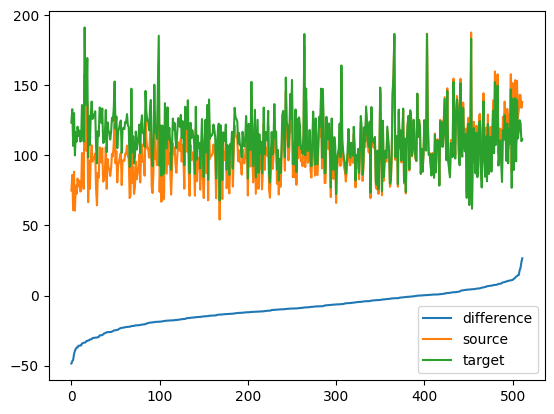

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

diff = source_divergence - target_divergence
diff_index=np.argsort(diff)

plt.plot(diff[diff_index], label="difference")
plt.plot(source_divergence[diff_index],  label="source")
plt.plot(target_divergence[diff_index], label="target")
plt.legend()


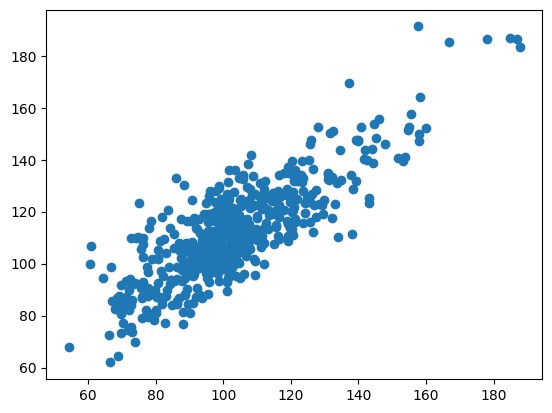

In [14]:
plt.scatter(source_divergence, target_divergence)

Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10c/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_0.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10c/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_1.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10c/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_2.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10c/adapted/pretrain-learner-0_pretrain-learner-200_resnet18_123_bins_0.01_3.pth.tar
Loaded model from ./ckpts/cifar10test/adapted/pretrain-learn

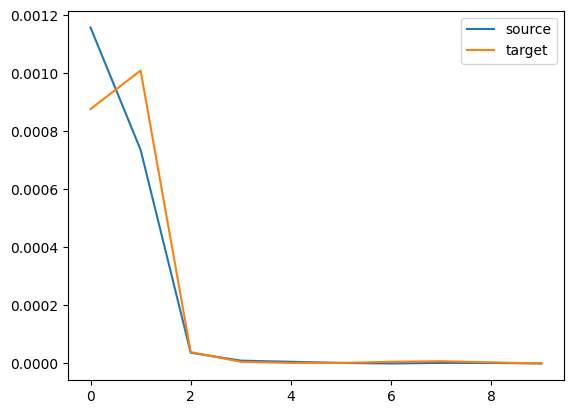

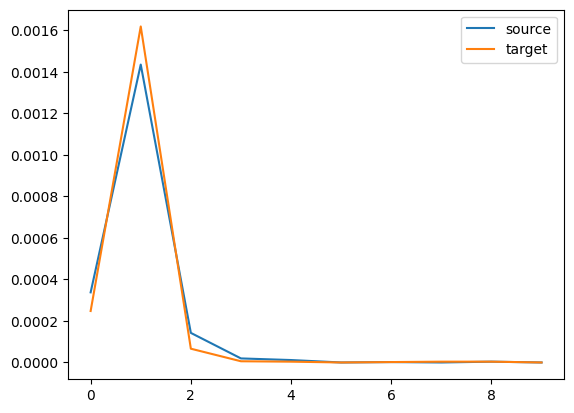

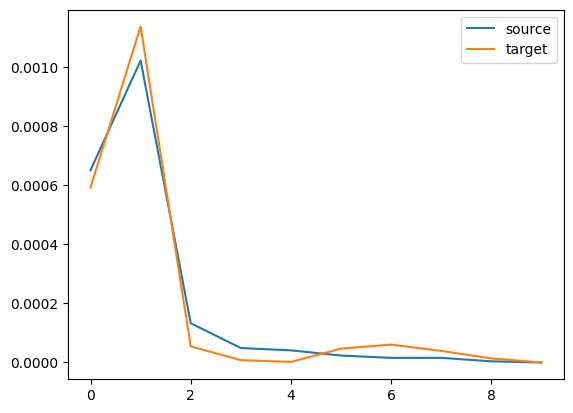

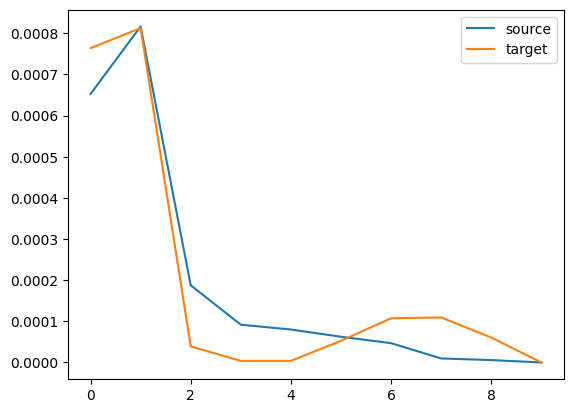

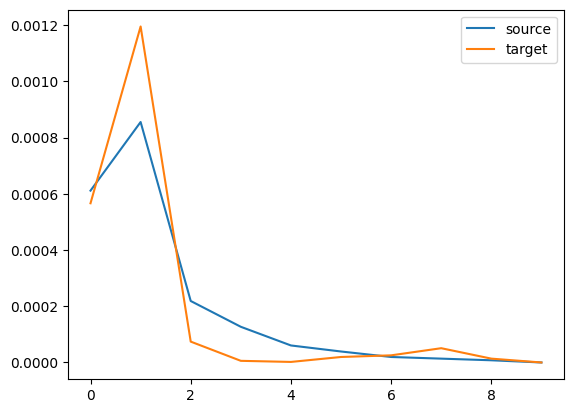

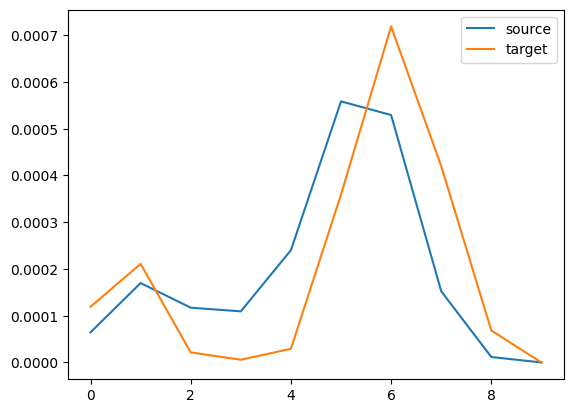

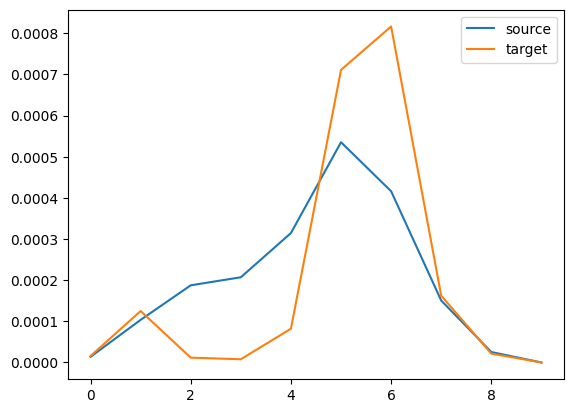

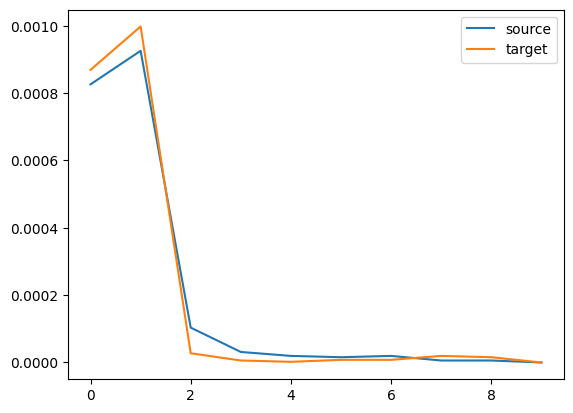

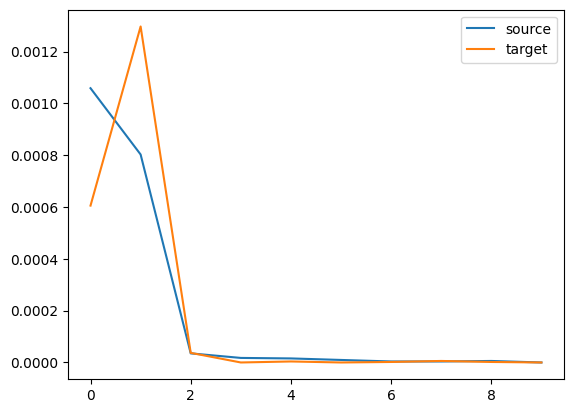

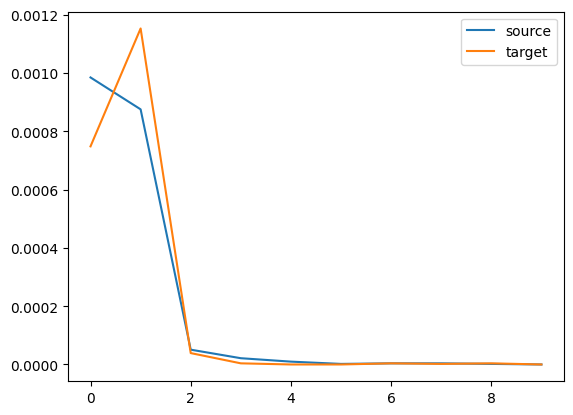

In [15]:
for class_num in range(10):
    plt.figure(class_num)
    vis_histogram(source_ckpt_dir, target_ckpt_dir, class_num=class_num, feat_index=1)